## Introduction

We aim at this project to estime house Prices based on some specific features ( that we will show you later). we are given a data set of 1460 homes, each with 81 features of types: float, integer, and categorical. We are trying to build the best possible regression model to estimate a home's sale price. 

## Import the libraries

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings("ignore")

## Load the datasets

In [5]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [6]:
# Let's take a look at the first rows of the datasets
df_train.head()
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Description of the features (see readme file)

In [7]:
#Get the shape of the datasets
trainshape = ("Train Data:",df_train.shape[0],"obs, and", df_train.shape[1], "features" )
print("\033[95m {}\033[00m" .format(trainshape))
testshape = ("Test Data:",df_test.shape[0],"obs, and", df_test.shape[1], "features" )
print("\033[95m {}\033[00m" .format(testshape))

 ('Train Data:', 1460, 'obs, and', 81, 'features')
 ('Test Data:', 1459, 'obs, and', 80, 'features')


In [8]:
#Let's first get the Id of the items and save them to a variable that we might need later for our Analysis
# save id 
train_id = df_train["Id"]
test_id = df_test["Id"]

# drop id
df_train.drop("Id" , axis = 1 , inplace = True)
df_test.drop("Id" , axis = 1 , inplace = True)

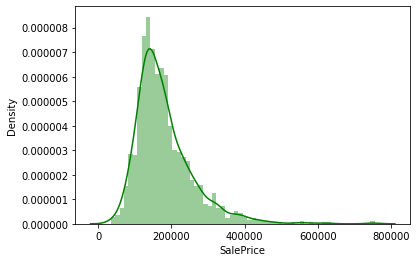

In [11]:
# Let's take a look at the target variable "SalePrice"
sns.distplot(df_train["SalePrice"] , color = "g", bins = 60 , hist_kws={"alpha": 0.4});

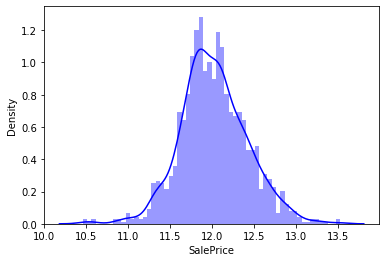

In [12]:
# As you can see above, the target variable SalePrice is not distributed normally.
# For more robustness we will log transform the target variable using 
sns.distplot(np.log1p(df_train["SalePrice"]) , color = "b", bins = 60 , hist_kws={"alpha": 0.4});


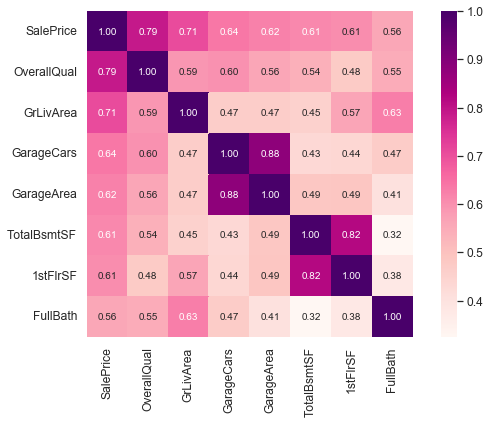

In [13]:
# Let's create the best 8 correlation with heatmap.
corrmatrix = df_train.corr()
plt.figure(figsize = (10,6))
columnss = corrmatrix.nlargest(8, "SalePrice")["SalePrice"].index
cm = np.corrcoef(df_train[columnss].values.T)
sns.set(font_scale = 1.1)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, cmap = "RdPu" ,  fmt = ".2f", annot_kws = {"size": 10},
                 yticklabels = columnss.values, xticklabels = columnss.values)
plt.show()

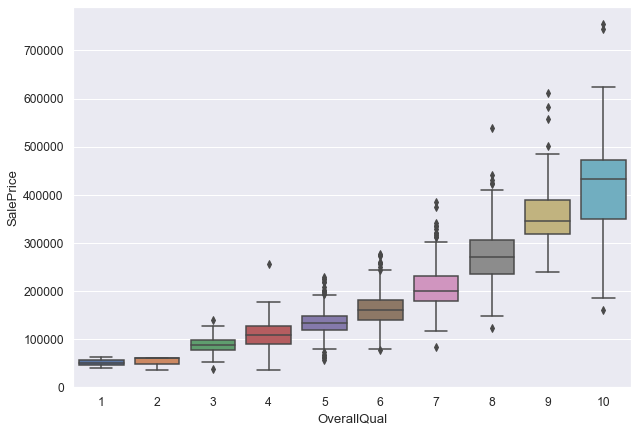

In [15]:
#Now let's look at the distribution of the variable with the 3 highest correlations
f, ax = plt.subplots(figsize = (10, 7))
sns.boxplot(x = "OverallQual", y = "SalePrice", data = df_train);

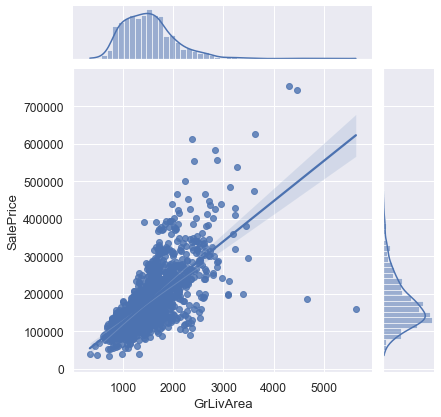

In [16]:
sns.jointplot(x = df_train["GrLivArea"], y = df_train["SalePrice"], kind = "reg");

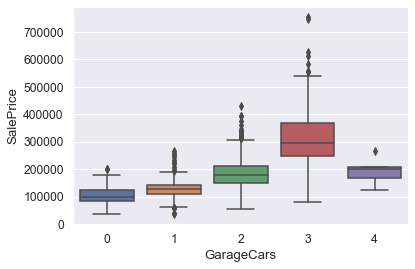

In [17]:
sns.boxplot(x = df_train["GarageCars"], y = df_train["SalePrice"]);

In [21]:
# We need to remove outliers.
df_train = df_train.drop(df_train[(df_train["GrLivArea"] > 4000) 
                         & (df_train["SalePrice"] < 200000)].index).reset_index(drop = True)
df_train = df_train.drop(df_train[(df_train["GarageCars"] > 3) 
                         & (df_train["SalePrice"] < 300000)].index).reset_index(drop = True)

In [22]:
# Next step is to concanete train and test data for some cleaning operations.
df = pd.concat((df_train, df_test)).reset_index(drop = True)
df.drop(["SalePrice"], axis = 1, inplace = True)
df.shape

(2912, 79)

## Cleaning the data

#### Missing data

We will impute NaN data <br>
We have to distinguish between categorical and numeric data missing data.

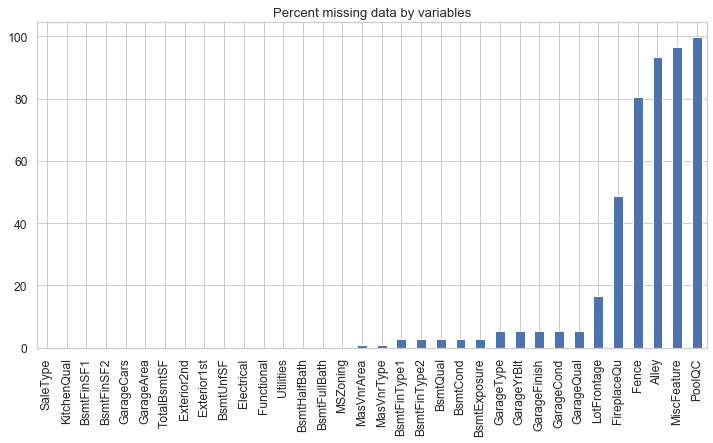

In [23]:
sns.set_style("whitegrid")
f , ax = plt.subplots(figsize = (12, 6))
miss = round(df.isnull().mean()*100,2)
miss = miss[miss > 0]
miss.sort_values(inplace = True)
miss.plot.bar(color = "b")
ax.set(title="Percent missing data by variables");

In [24]:
some_miss_columns = ["PoolQC","MiscFeature","Alley","Fence","FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond",
                  "BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","MasVnrType","MSSubClass"]

for i in some_miss_columns :
        df[i].fillna("None" , inplace = True)

In [25]:
df["Functional"] = df["Functional"].fillna("Typ")

In [26]:
some_miss_columns2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities","MSZoning",
                      "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd","MasVnrArea"]
for i in some_miss_columns2:
    df[i].fillna(df[i].mode()[0], inplace = True)

In [27]:
some_miss_columns3 = ["GarageYrBlt", "GarageArea", "GarageCars","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF"]
for i in some_miss_columns3 :
    df[i] = df[i].fillna(0)

In [28]:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [29]:
# All  NaN data have been treated successfully 
df.isna().sum().nlargest(3)

1stFlrSF     0
2ndFlrSF     0
3SsnPorch    0
dtype: int64

In [30]:
## Transform for some variables
Nm = ["MSSubClass","MoSold","YrSold"]
for col in Nm:
    df[col] = df[col].astype(str)

In [31]:
#Label Encoding
label = LabelEncoder()
encodecolumns = ("FireplaceQu","BsmtQual","BsmtCond","ExterQual","ExterCond","HeatingQC","GarageQual",
                "GarageCond","PoolQC","KitchenQual","BsmtFinType1","BsmtFinType2","Functional","Fence",
                "BsmtExposure","GarageFinish","LandSlope","LotShape","PavedDrive","Street","Alley",
                "CentralAir","MSSubClass","OverallCond","YrSold","MoSold")
for i in encodecolumns :
    label.fit(list(df[i].values))
    df[i] = label.transform(list(df[i].values))

In [33]:
#log Transform of the target variable
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
y = df_train.SalePrice.values
y[:5]

array([12.24769912, 12.10901644, 12.31717117, 11.84940484, 12.4292202 ])

In [35]:
numeric = df.dtypes[df.dtypes != "object"].index
skewed_var = df[numeric].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame({"Skewed Features" :skewed_var})
skewness.head()

# Apply a Box Cox transformation
skewness = skewness[abs(skewness) > 0.75]
skewed_var2 = skewness.index
for i in skewed_var2:
    df[i] = boxcox1p(df[i], 0.15)
    df[i] += 1

In [36]:
# OneHotEncoding
df = pd.get_dummies(df)
df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Utilities_AllPub,Utilities_NoSeWa
0,12.692623,12.686189,1.0,1.730463,2.540963,2.820334,2.540963,12.170327,1.0,2.194318,...,0,0,0,0,0,0,0,1,1,0
1,13.792276,1.000000,1.0,1.730463,2.540963,2.820334,1.730463,13.062832,1.0,1.000000,...,0,0,0,0,0,0,0,1,1,0
2,12.892039,12.724598,1.0,1.730463,2.540963,2.820334,2.194318,11.200343,1.0,2.194318,...,0,0,0,0,0,0,0,1,1,0
3,13.013683,12.354094,1.0,1.730463,2.540963,1.730463,2.540963,9.274266,1.0,1.000000,...,0,0,0,0,0,0,0,1,1,0
4,13.510588,13.271365,1.0,1.730463,2.820334,2.820334,1.000000,11.971129,1.0,2.194318,...,0,0,0,0,0,0,0,1,1,0


In [37]:
X_train = df[:df_train.shape[0]]
X_test = df[df_train.shape[0]:]

Since we have too many variables it would make sense to apply some Principal Component Analysis to reduce the Complexity of the data!

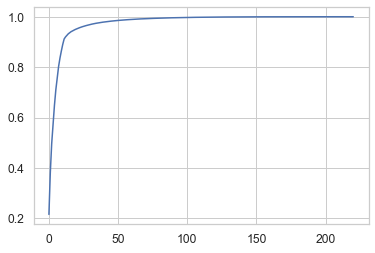

In [40]:
df2 = df.copy()
df_standardize = StandardScaler().fit_transform(df2)
##I didn't standardize it again because the data is already close to the standard.
pca = PCA()
pca_fit = pca.fit_transform(df2)
pca = PCA().fit(df2)
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [41]:
#We suggest to use the first 30 Components for further Computations
pca = PCA(n_components = 30)
pca_fit = pca.fit_transform(df2)
pca_df = pd.DataFrame(data = pca_fit)
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.310874,-7.644388,-3.190557,-6.130242,-1.231003,1.802676,0.149904,1.802519,-0.081996,-1.064012,...,0.016467,0.701729,-0.548067,0.057766,0.325643,-0.308620,-0.267495,0.076198,0.134885,-0.157174
1,-6.792759,0.934007,-1.220512,5.201498,1.143536,-3.922942,-3.233540,0.318292,-1.110764,-0.084848,...,0.260304,0.464323,0.048632,-0.340159,0.503028,1.360858,-0.353393,0.118229,-0.688542,0.823472
2,2.258800,-7.309320,-1.561536,-5.963476,-1.504997,0.673385,-0.047281,0.567739,-0.445352,-0.352704,...,-0.053163,0.248898,0.115803,0.155388,0.597306,-0.630828,-0.284593,-0.266044,0.156553,-0.238708
3,5.713698,-1.996913,-4.386689,-2.343667,-4.081766,-3.358525,-0.259982,-2.570543,6.024252,-1.719936,...,0.129809,-1.489415,0.627429,-0.343844,0.903284,0.817787,1.098169,0.308707,-0.449618,-0.323053
4,0.639671,-12.038284,0.643347,-0.953167,2.368347,0.493921,-0.421904,0.242407,0.724364,-0.126743,...,-0.270478,-0.100020,0.311128,0.419949,0.933242,-0.265696,-0.182271,0.105923,0.237448,0.347396


## Building the Models 

In [42]:
# Define the metric (using KFold Cross_Validation)
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y, scoring = "neg_mean_squared_error", cv = kf))
    return(rmse)

In [43]:
# Define the models
model_xgb = xgb.XGBRegressor(colsample_bytree = 0.2, gamma = 0.0 ,
                             learning_rate = 0.05, max_depth = 6, 
                             min_child_weight = 1.5, n_estimators = 7200,
                             reg_alpha = 0.9, reg_lambda = 0.6,
                             subsample = 0.2,seed = 42,
                             random_state = 7)

model_gbm = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                   max_depth = 4, max_features = "sqrt",
                                   min_samples_leaf = 15, min_samples_split = 10, 
                                   loss = "huber", random_state = 5)

In [44]:
score = rmsle_cv(model_xgb)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_gbm)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std())) 

XGBoost score: 0.1190 (0.0059)

Gradient Boosting score: 0.1176 (0.0077)



### XGBoost

In [46]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [47]:
model_xgb.fit(X_train, y)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y, xgb_train_pred))

0.04264261490431553


### GBM (Gradient Boosting Machines)

In [48]:
model_gbm.fit(X_train, y)
gbm_train_pred = model_gbm.predict(X_train)
gbm_pred = np.expm1(model_gbm.predict(X_test.values))
print(rmsle(y, gbm_train_pred))

0.049905900570324804


# SUBMISSION

In [49]:
best = (0.5 * xgb_pred ) + (0.5 * gbm_pred)

In [50]:
submission = pd.DataFrame({"Id": test_id, "SalePrice": best})
submission.head(5)

,Id,SalePrice
0,1461,125136.450045
1,1462,154933.692106
2,1463,184559.612965
3,1464,199323.776890
4,1465,186425.099155


In [51]:
submission.to_csv("submission.csv", index = False)